In [77]:
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import (create_engine, Table, Column, Integer, String, MetaData, inspect)
import pandas as pd
import pymysql.cursors
import mysql.connector
import numpy as np
import math
import nltk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import mixture
%matplotlib inline

In [81]:
############ CONNECT TO THE DATABASE - OSX/Windows ############
# connection = pymysql.connect(host='localhost',
#                              user='root',
#                              password='root',#put your password for mysql server here.
#                              db='yelp_db',
#                              charset='utf8mb4',
#                              cursorclass=pymysql.cursors.DictCursor)

############ CONNECT TO THE DATABASE - RHEL ############
connection = mysql.connector.connect(
    user='root',
    password='root',
    host='127.0.0.1',
    port=3306,
    database='yelp_db')

data = pd.read_sql('''
select business.id,
  business.name,
  business.latitude,
  business.longitude,
  business.city,
  business.neighborhood,
  category.category
  FROM category
  inner join business on
  business.id = category.business_id
  WHERE business.city ="Pittsburgh"
  and neighborhood IS NOT NULL
  and category.category = "Italian"
  or category.category = "Chinese"
  or category.category = "Mexican"
  or category.category = "American (New)"
  or category.category = "Korean"
  or category.category = "Japanese"
  or category.category = "Thai"
  or category.category = "Indian"
  GROUP BY business.id, category.category''',connection) #.values


# or category.category = "Mediterranean"
#   or category.category = "Greek"
#   or category.category = "French"
# or category.category = "Turkish"
#   or category.category = "Caribbean"
#   or category.category = "Vietnamese"
#   or category.category = "Latin American"
#   or category.category = "Taiwanese"

In [82]:
#### CLUSTERING BY NEIGHBORHOOD
dfh = data[['latitude','longitude','city','neighborhood','category']]
dfh = dfh.loc[dfh['city'] == 'Pittsburgh']
dfh = dfh[['latitude','longitude','neighborhood','category']]

neighborhoods = dfh.neighborhood.unique()
#print(dfh)

In [83]:
dfh.neighborhood.value_counts() # there are 46 neighborhoods

                     279
Downtown             125
Oakland               76
South Side            59
Squirrel Hill         46
Bloomfield            38
Shadyside             36
Lawrenceville         33
North Side            31
Strip District        25
East Liberty          14
Dormont               13
Beechview              9
Brookline              9
Banksville             8
Mt. Washington         7
Carrick                7
The Hill District      7
Greentree              7
Greenfield             6
Garfield               5
Aspinwall              5
Duquesne Heights       5
West View              4
Highland Park          4
West End               4
Emsworth               3
Friendship             3
Troy Hill              2
Bellevue               2
Allentown              2
Sharpsburg             2
Point Breeze           1
Etna                   1
Avalon                 1
Knoxville              1
Carnegie               1
Larimer                1
Homestead              1
Morningside            1


In [84]:
dfh.category.value_counts()

American (New)    281
Italian           207
Chinese           128
Mexican           112
Japanese           59
Thai               53
Indian             35
Korean             15
Name: category, dtype: int64

In [85]:
dfh['neighborhood'].replace('',0,inplace=True)
dfh['neighborhood'].replace('Downtown',1, inplace=True)
dfh['neighborhood'].replace('Oakland',2, inplace=True)
dfh['neighborhood'].replace('South Side',3, inplace=True)
dfh['neighborhood'].replace('Squirrel Hill',4, inplace=True)
dfh['neighborhood'].replace('Shadyside',5, inplace=True)
dfh['neighborhood'].replace('Lawrenceville',6, inplace=True)
dfh['neighborhood'].replace('Bloomfield',7, inplace=True)
dfh['neighborhood'].replace('Strip District',8, inplace=True)
dfh['neighborhood'].replace('North Side',9, inplace=True)
dfh['neighborhood'].replace('East Liberty',10, inplace=True)
dfh['neighborhood'].replace('Dormont',11, inplace=True)
dfh['neighborhood'].replace('Brookline',12, inplace=True)
dfh['neighborhood'].replace('Beechview',13, inplace=True)
dfh['neighborhood'].replace('Carrick',14, inplace=True)
dfh['neighborhood'].replace('Banksville',15, inplace=True)
dfh['neighborhood'].replace('Garfield',16, inplace=True)
dfh['neighborhood'].replace('West View',17, inplace=True)
dfh['neighborhood'].replace('Mt. Washington',18, inplace=True)
dfh['neighborhood'].replace('Greentree',19, inplace=True)
dfh['neighborhood'].replace('The Hill District',20, inplace=True)
dfh['neighborhood'].replace('Regent Square',21, inplace=True)
dfh['neighborhood'].replace('Aspinwall',22, inplace=True)
dfh['neighborhood'].replace('Greenfield',23, inplace=True)
dfh['neighborhood'].replace('Highland Park',24, inplace=True)
dfh['neighborhood'].replace('West End',25, inplace=True)
dfh['neighborhood'].replace('Duquesne Heights',26, inplace=True)
dfh['neighborhood'].replace('Bellevue',27, inplace=True)
dfh['neighborhood'].replace('Friendship',28, inplace=True)
dfh['neighborhood'].replace('Allentown',29, inplace=True)
dfh['neighborhood'].replace('Emsworth',30, inplace=True)
dfh['neighborhood'].replace('Point Breeze',31, inplace=True)
dfh['neighborhood'].replace('Larimer',32, inplace=True)
dfh['neighborhood'].replace('Troy Hill',33, inplace=True)
dfh['neighborhood'].replace('Sharpsburg',34, inplace=True)
dfh['neighborhood'].replace('Carnegie',35, inplace=True)
dfh['neighborhood'].replace('Avalon',36, inplace=True)
dfh['neighborhood'].replace('Etna',37, inplace=True)
dfh['neighborhood'].replace('Bon Air',38, inplace=True)
dfh['neighborhood'].replace('South Side Slopes',39, inplace=True)
dfh['neighborhood'].replace('Knoxville',40, inplace=True)
dfh['neighborhood'].replace('East Carnegie',41, inplace=True)
dfh['neighborhood'].replace('Overbrook',42, inplace=True)
dfh['neighborhood'].replace('Mt. Oliver',43, inplace=True)
dfh['neighborhood'].replace('Morningside',44, inplace=True)
dfh['neighborhood'].replace('Homestead',45, inplace=True)


In [86]:
# drop all the neighborhoods except the top 14
dfh = dfh[dfh.neighborhood != 0]
dfh = dfh[dfh.neighborhood != 15]
dfh = dfh[dfh.neighborhood != 16]
dfh = dfh[dfh.neighborhood != 17]
dfh = dfh[dfh.neighborhood != 18]
dfh = dfh[dfh.neighborhood != 19]
dfh = dfh[dfh.neighborhood != 20]
dfh = dfh[dfh.neighborhood != 21]
dfh = dfh[dfh.neighborhood != 22]
dfh = dfh[dfh.neighborhood != 23]
dfh = dfh[dfh.neighborhood != 24]
dfh = dfh[dfh.neighborhood != 25]
dfh = dfh[dfh.neighborhood != 26]
dfh = dfh[dfh.neighborhood != 27]
dfh = dfh[dfh.neighborhood != 28]
dfh = dfh[dfh.neighborhood != 29]
dfh = dfh[dfh.neighborhood != 30]
dfh = dfh[dfh.neighborhood != 31]
dfh = dfh[dfh.neighborhood != 32]
dfh = dfh[dfh.neighborhood != 33]
dfh = dfh[dfh.neighborhood != 34]
dfh = dfh[dfh.neighborhood != 35]
dfh = dfh[dfh.neighborhood != 36]
dfh = dfh[dfh.neighborhood != 37]
dfh = dfh[dfh.neighborhood != 38]
dfh = dfh[dfh.neighborhood != 39]
dfh = dfh[dfh.neighborhood != 40]
dfh = dfh[dfh.neighborhood != 41]
dfh = dfh[dfh.neighborhood != 42]
dfh = dfh[dfh.neighborhood != 43]
dfh = dfh[dfh.neighborhood != 44]
dfh = dfh[dfh.neighborhood != 45]
dfh = dfh[dfh.neighborhood != 46]

new_dfh = dfh[['latitude','longitude']].copy()
#new_dfh.drop('neighborhood', 1, inplace=True)
#new_dfh.drop('category', 1, inplace=True)

from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(new_dfh)
pca_2d = pca.transform(new_dfh) #transform, fit
#W = pca_2d.components_
#X_proj = np.matrix(new_dfh)*W.T

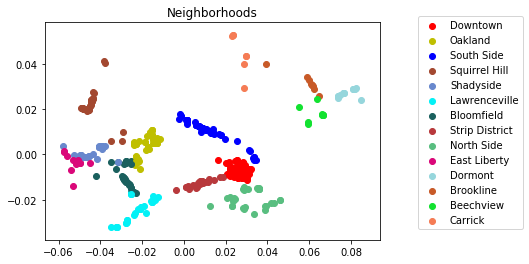

In [87]:
import pylab as pl
values = dfh.neighborhood.tolist()

for i in range(0, pca_2d.shape[0]): # X_proj
#     if values[i] == 0:
#         c0= pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g')
    if values[i] == 1:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r')
    elif values[i] == 2:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y')
    elif values[i] == 3:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b')
    elif values[i] == 4:
        c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#A34830')
    elif values[i] == 5:
        c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#6888CD')
    elif values[i] == 6:
        c6 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#03F1F6')
    elif values[i] == 7:
        c7 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#1A605E')
    elif values[i] == 8:
        c8 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#B8393C')
    elif values[i] == 9:
        c9 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#59BE80')
    elif values[i] == 10:
        c10 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#DA0779')
    elif values[i] == 11:
        c11 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#96D6DC')
    elif values[i] == 12:
        c12 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#C85A28')
    elif values[i] == 13:
        c13 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#12E230')
    elif values[i] == 14:
        c14 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#F57C55')

pl.legend([c1, c2, c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14], #c0,
          ['Downtown', 'Oakland','South Side','Squirrel Hill','Shadyside','Lawrenceville',
                        'Bloomfield','Strip District','North Side','East Liberty','Dormont','Brookline',
                         'Beechview','Carrick'],bbox_to_anchor=(1.1, 1.05)) #'None',
pl.title('Neighborhoods')
pl.show()

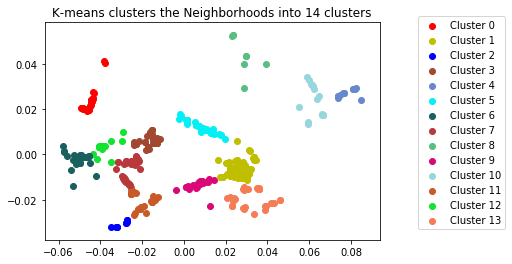

In [95]:
test_dfh = dfh[['latitude','longitude']].copy()
pca_test = PCA(n_components=2).fit(test_dfh)
pca_2d_test = pca_test.transform(test_dfh)

kmeans = KMeans(n_clusters=14, random_state=111)
kmeans.fit(test_dfh)
plt.figure('K-means with 14 clusters')
#plt.scatter(pca_2d_test[:, 0], pca_2d_test[:, 1], c=kmeans.labels_)

for i in range(0, pca_2d_test.shape[0]):
    if kmeans.labels_[i] == 0:
        c15 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='r')
    elif kmeans.labels_[i] == 1:
        c16 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='y')
    elif kmeans.labels_[i] == 2:
        c17 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='b')
    elif kmeans.labels_[i] == 3:
        c18 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#A34830')
    elif kmeans.labels_[i] == 4:
        c19 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#6888CD')
    elif kmeans.labels_[i] == 5:
        c20 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#03F1F6')
    elif kmeans.labels_[i] == 6:
        c21 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#1A605E')
    elif kmeans.labels_[i] == 7:
        c22 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#B8393C')
    elif kmeans.labels_[i] == 8:
        c23 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#59BE80')
    elif kmeans.labels_[i] == 9:
        c24 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#DA0779')
    elif kmeans.labels_[i] == 10:
        c25 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#96D6DC')
    elif kmeans.labels_[i] == 11:
        c26 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#C85A28')
    elif kmeans.labels_[i] == 12:
        c27 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#12E230')
    elif kmeans.labels_[i] == 13:
        c28 = plt.scatter(pca_2d_test[i,0],pca_2d_test[i,1],c='#F57C55')


plt.legend([c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28],
          ['Cluster 0','Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5','Cluster 6',
          'Cluster 7', 'Cluster 8','Cluster 9','Cluster 10', 'Cluster 11','Cluster 12',
          'Cluster 13'],bbox_to_anchor=(1.1, 1.05))
plt.title('K-means clusters the Neighborhoods into 14 clusters')
plt.show()

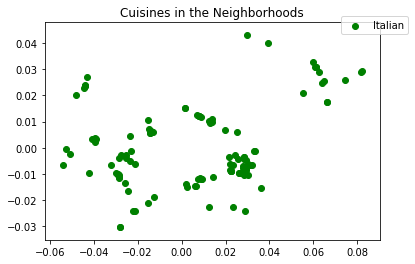

In [89]:
## KEEP IN CATEGORY
dfh['category'].replace('Italian',0,inplace=True)
dfh['category'].replace('Chinese',1, inplace=True)
dfh['category'].replace('Mexican',2, inplace=True)
dfh['category'].replace('American (New)',3, inplace=True)
dfh['category'].replace('Mediterranean',4, inplace=True)
dfh['category'].replace('Japanese',5, inplace=True)
dfh['category'].replace('Thai',6, inplace=True)
dfh['category'].replace('Indian',7, inplace=True)
dfh['category'].replace('Middle Eastern',8, inplace=True)
dfh['category'].replace('Greek',9, inplace=True)
dfh['category'].replace('French',10, inplace=True)
dfh['category'].replace('Korean',11, inplace=True)
dfh['category'].replace('Turkish',12, inplace=True)
dfh['category'].replace('Caribbean',13, inplace=True)
dfh['category'].replace('Vietnamese',14, inplace=True)
dfh['category'].replace('Latin American',15, inplace=True)
dfh['category'].replace('Taiwanese',16, inplace=True)

## FOR TESTING SPECIFIC CUISINE
test_dfh = dfh[['latitude','longitude']].copy()
pca_test = PCA(n_components=2).fit(test_dfh)
pca_2d_test = pca_test.transform(test_dfh)

kmeans = KMeans(n_clusters=17, random_state=111)
kmeans.fit(test_dfh)
#plt.figure('K-means with 14 clusters')
#plt.scatter(pca_2d_test[:, 0], pca_2d_test[:, 1], c=kmeans.labels_)

values = dfh.category.tolist()

for i in range(0, pca_2d.shape[0]):
    if values[i] == 0:
        c0= pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g')
#     if values[i] == 0:
#         c0= pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g')
#     elif values[i] == 1:
#         c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r')
#     elif values[i] == 2:
#         c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y')
#     elif values[i] == 3:
#         c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b')
#     elif values[i] == 4:
#         c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#A34830')
#     elif values[i] == 5:
#         c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#6888CD')
#     elif values[i] == 6:
#         c6 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#03F1F6')
#     elif values[i] == 7:
#         c7 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#1A605E')
#     elif values[i] == 8:
#         c8 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#B8393C')
#     elif values[i] == 9:
#         c9 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#59BE80')
#     elif values[i] == 10:
#         c10 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#DA0779')
#     elif values[i] == 11:
#         c11 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#96D6DC')
#     elif values[i] == 12:
#         c12 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#C85A28')
#     elif values[i] == 13:
#         c13 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#12E230')
#     elif values[i] == 14:
#         c14 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#F57C55')
#     elif values[i] == 15:
#         c15 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#32FAA8')
#     elif values[i] == 16:
#         c16 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='#DEAEA8')

# pl.legend([c0,c1, c2, c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16],
#           ['Italian', 'Chinese','Mexican','American (New)','Mediterranean','Japanese',
#                         'Thai','Indian','Middle Eastern','Greek','French','Korean',
#                          'Caribbean','Vietnamese','Latin American','Taiwanese'
#           ],bbox_to_anchor=(1.1, 1.05)) #'None',


pl.legend([c0],['Italian'],bbox_to_anchor=(1.1, 1.05)) #'None',


pl.title('Cuisines in the Neighborhoods')
pl.show()

In [90]:
##### PREVIOUS WORK STARTS HERE
#df = data[['latitude','longitude','city','category']]
#df = df.loc[df['city'] == 'Pittsburgh']
#df = df[['latitude','longitude','category']]

## TODO - RECENT ADDITIONS
df = dfh[['latitude','longitude','category','neighborhood']].copy() # ADDED
df[['latitude','longitude']] = (df[['latitude','longitude']].sub(df[['latitude','longitude']].mean())).divide(df[['latitude','longitude']].std())

## ADDED
df['category'].replace(0,'Italian',inplace=True)
df['category'].replace(1,'Chinese', inplace=True)
df['category'].replace(2,'Mexican', inplace=True)
df['category'].replace(3,'American (New)', inplace=True)
df['category'].replace(4,'Mediterranean', inplace=True)
df['category'].replace(5,'Japanese', inplace=True)
df['category'].replace(6,'Thai', inplace=True)
df['category'].replace(7,'Indian', inplace=True)
df['category'].replace(8,'Middle Eastern', inplace=True)
df['category'].replace(9,'Greek', inplace=True)
df['category'].replace(10,'French', inplace=True)
df['category'].replace(11,'Korean', inplace=True)
df['category'].replace(12,'Turkish', inplace=True)
df['category'].replace(13,'Caribbean', inplace=True)
df['category'].replace(14,'Vietnamese', inplace=True)
df['category'].replace(15,'Latin American', inplace=True)
df['category'].replace(16,'Taiwanese', inplace=True)
## END ADD

## ADDED - remove all neighborhoods and only focus on one with its cuisines, keep 1 and 7 (Bloomfield), Squirrel Hill (4)
# df = df[df.neighborhood != 2]
# df = df[df.neighborhood != 3]
# df = df[df.neighborhood != 7]
# df = df[df.neighborhood != 5]
# df = df[df.neighborhood != 6]
# df = df[df.neighborhood != 1]
# df = df[df.neighborhood != 8]
# df = df[df.neighborhood != 9]
# df = df[df.neighborhood != 10]
# df = df[df.neighborhood != 11]
# df = df[df.neighborhood != 12]
# df = df[df.neighborhood != 13]
## END ADD


topDf = df.copy()
categoryList = df['category'].tolist()

def topCategories(categoryList):
    n = []
    for i in categoryList:
         n += [i.split(',')]   
    count={}
    for i in n:
        for j in i:
            if j not in count:
                count[j]=1
            else:
                count[j] = count[j] +1
    return OrderedDict(sorted(count.items(), key=lambda a:a[1], reverse=True))    

def convert(j):
    for i in top:
        if(i == j):
            return(top.index(i)+1)
        
top = list(topCategories(categoryList))[0:15]
topCatNames=[]
topCatNames = top
c =[]
for i in df['category']:
    row = i.split(',')
    c += [[convert(j) for j in row if j in top]]
topDf['category'] = c
topDf = topDf.reset_index(drop = True)
a = np.zeros(shape=(len(topDf['category']),15))
i=0
for j in c:
    for k in j:
        a[i,k-1]=1
    i+=1
top = pd.DataFrame.from_records(a)
top[['latitude','longitude']] = topDf[['latitude','longitude']]

#print(top)

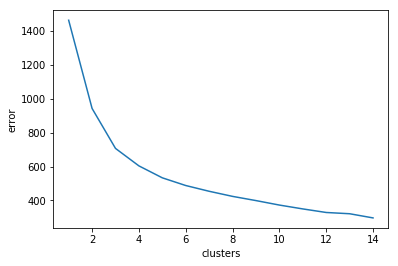

In [91]:
# evaluate the clusters
n = 15 # max clusters
error = np.zeros(n)
error[0] = 0;
for k in range(1,n):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(top)
    error[k] = kmeans.inertia_
plt.figure(1)
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('clusters')
plt.ylabel('error')

In [92]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=100) 
km = kmeans.fit_predict(top)
labels = kmeans.labels_

silhouette_score(top, kmeans.labels_)

0.29981440606824272

In [102]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score([0, 0, 1, 1], kmeans.labels_)

[ 7  7  0  1  1  1  7 13  7  7  1  1 11 11  1 12  0  5  7  8  7  1  3  0  0
  0  6  1  2 11  0  5  1  1  7  7  1  1  3  1  7  7 12  7  1  1  3  7  1  7
  5 11  4  3  5  1  1  3 13  6  0 13  7  1  3  1  6  1 13  9 10  1 10  6  4
 13 13  5  5  1 11 11  1  1 11 11 11  0  6 13  1  7  9  5  7  1  3 12  1 13
  5  5 12  1  1 13  4  4 12  5  3  3  7  7  0  6  0  0  0  0  9  6  1  1  3
  5  5  5  1  1  9  3  9  5  5  6  9  1  0 10  5  7  3  4  4  1 11 11  1  0
 13  6  5  1  9  1  6  1 11  8  2  0  1 10 12  3  2  7  9  9 11  2  9  7  1
  1  1  6  3 12  1  1 10 11  6  1 11 12 12  6  7  1 10  7 13  9  6  2  3  9
  1 10  3  3  3  4  6  1  7  7  1  1  8  1  3  7  1  1  1  0  1  1  6  6 10
 10 11 11  0  5  7  6  1  1 11  5 11 13  1  1 10 12  5  6 13  3  3  1  5  0
  5  5  1  1  0 12  2 11 11  5  5 13  3  3  1 12  0  2  1 11  5  3  3 11  1
  5 13  1  3 12 12  5 13  1  1  7 12  3 11 11  0  1  1  1  1  9  0  1  0  1
  5  3  1  3  1  1  9  1  5  5  5  3  3  1  7  5  5  4 13  5  8  1  0  3  1
  1  1  7  3

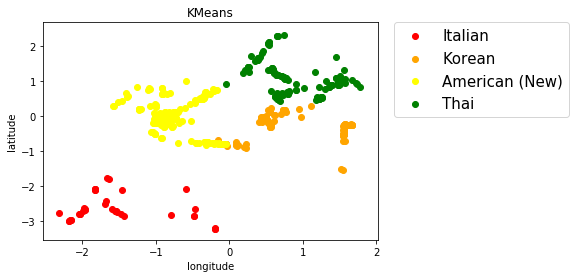

In [98]:
def createCentroids(centroids):
    y = 0  
    for i in centroids:
        plt.scatter(i[15],i[16],s=50,c='black',marker='*',linewidth=2)
        plt.annotate(labelsKm[y],xy=(i[15],i[16]))
        y+=1
    
def createScatter(clusters):
    colors = ['red','orange','yellow','green','blue','purple']
    x = 0
    for i in clusters:
        for j in i:
            plt.scatter(top['longitude'][j],top['latitude'][j], color=colors[x]) #org: lat, long
        x=x+1
        
def labels(cluster):
    count = {}
    for i in cluster[0]:
        for j in topDf['category'][i]:
            if j not in count:
                count[j] = 1
            else:
                count[j] +=1
    return OrderedDict(sorted(count.items(), key=lambda kv:kv[1], reverse=True))

def clusterLabel(lc,topCounts):
    maxx = 0
    for key,value in lc.items():
        temp = value/topCounts[key-1]
        if(temp>maxx):
            maxx = temp
            index = key-1
    return topCatNames[index]

topCounts = list(topCategories(categoryList).values())[0:15]
labelsKm = []
km0 = np.where(km==0)
lc = labels(km0)
labelsKm.append(clusterLabel(lc, topCounts))
km1 = np.where(km==1)
lc = labels(km1)
labelsKm.append(clusterLabel(lc, topCounts))

km2 = np.where(km==2)
lc = labels(km2)
labelsKm.append(clusterLabel(lc, topCounts))

km3 = np.where(km==3)
lc = labels(km3)
labelsKm.append(clusterLabel(lc, topCounts))

# km4 = np.where(km==4)
# lc = labels(km4)
# labelsKm.append(clusterLabel(lc, topCounts))

# km5 = np.where(km==5)
# lc = labels(km5)
# labelsKm.append(clusterLabel(lc, topCounts))


clusters = [km0,km1,km2,km3] # ,km2,km3,km4,km5
createScatter(clusters)
#createCentroids(kmeans.cluster_centers_)

plt.title('KMeans')
plt.xlabel('longitude') # latitude
plt.ylabel('latitude')
legend = plt.legend([labelsKm[i] for i in range(len(labelsKm))],bbox_to_anchor=(1.05, 1),
                    loc=2, borderaxespad=0.,fontsize=15)
plt.show()

/root/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: 

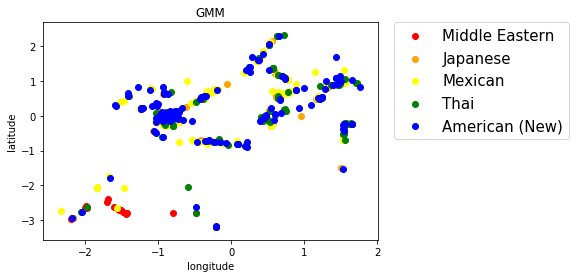

In [15]:
labelsGmm=[]
gmm = mixture.GMM(n_components=5)
gmm.fit(top)
gaussian = gmm.predict(top)
g0 = np.where(gaussian==0)
x= labels(g0)
labelsGmm.append(clusterLabel(x, topCounts))
g1 = np.where(gaussian==1)
x= labels(g1)
labelsGmm.append(clusterLabel(x, topCounts))
g2 = np.where(gaussian==2)
x= labels(g2)
labelsGmm.append(clusterLabel(x, topCounts))
g3 = np.where(gaussian==3)
x = labels(g3)
labelsGmm.append(clusterLabel(x, topCounts))
g4 = np.where(gaussian==4)
x = labels(g4)
labelsGmm.append(clusterLabel(x, topCounts))


clustersGmm = [g0,g1,g2,g3,g4 ] #,g4
createScatter(clustersGmm)
plt.title('GMM')
plt.xlabel('longitude') #latitude
plt.ylabel('latitude') #longitude
legend = plt.legend([labelsGmm[i] for i in range(len(labelsGmm))],bbox_to_anchor=ba, loc=2, borderaxespad=0.,fontsize=15)
plt.show()

63


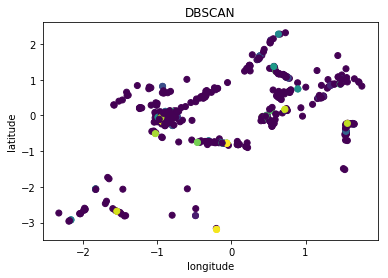

In [16]:
from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pandas as pd


def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

X = df[['latitude','longitude']]#df[['latitude','longitude']]
#X[['latitude','longitude']] = (df[['latitude','longitude']].sub(df[['latitude','longitude']].mean())).divide(df[['latitude','longitude']].std())
distance_matrix = squareform(pdist(X, (lambda u,v: haversine(u,v))))

db = DBSCAN(eps=0.2, min_samples=2, metric='precomputed')
y_db = db.fit_predict(distance_matrix)
print(len(set(y_db)))
X['cluster'] = y_db

#print(X)

plt.scatter(X['longitude'], X['latitude'], c=X['cluster']) #latitude, long
plt.title('DBSCAN')
plt.xlabel('longitude') #latitude
plt.ylabel('latitude') #longitude
plt.show()